## Import Libraries

In [1]:
import gym
import cv2
import time
import json
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque

## Set Enviroment Parameter

In [2]:
ENVIRONMENT = "PongDeterministic-v0"
temp_env = gym.make(ENVIRONMENT)

print(temp_env.observation_space)
print(temp_env.action_space)
print(temp_env.env.get_action_meanings())

Box([[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
 

## Set Enviroment Manager

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Save models to file so you can test later
SAVE_MODELS = True  
# Models path for saving or loading
MODEL_PATH = "./model"  
# Save models at every X epoch
SAVE_MODEL_INTERVAL = 10 
# Train model while playing (Make it False when testing a model)
TRAIN_MODEL = True  

# Load model from file
LOAD_MODEL_FROM_FILE = False  
# Load Xth episode from file
LOAD_FILE_EPISODE = 285  

# Minibatch size that select randomly from mem for train nets
BATCH_SIZE = 64  

# Max episode
MAX_EPISODE = 600  
# Max step size for one episode
MAX_STEP = 10000  

# Max memory len
MAX_MEMORY_LEN = 40000
# Min memory len before start train
MIN_MEMORY_LEN = 6000  

GAMMA = 0.95  
ALPHA = 0.00025 
EPSILON_DECAY = 0.99  # Epsilon decay rate by step
# EPSILON_DECAY = 1  # Epsilon decay rate by step

RENDER_GAME_WINDOW = True  # Opens a new window to render the game (Won't work on colab default)

## DuelCNN Function

In [4]:
class DuelCNN(nn.Module):
    """
    CNN with Duel Algo. https://arxiv.org/abs/1511.06581
    """
    def __init__(self, h, w, output_size):
        super(DuelCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4,  out_channels=32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        convw, convh = self.conv2d_size_calc(w, h, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=3, stride=1)

        linear_input_size = convw * convh * 64  # Last conv layer's out sizes

        # Action layer
        self.Alinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Alrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Alinear2 = nn.Linear(in_features=128, out_features=output_size)

        # State Value layer
        self.Vlinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Vlrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Vlinear2 = nn.Linear(in_features=128, out_features=1)  # Only 1 node

    def conv2d_size_calc(self, w, h, kernel_size=5, stride=2):
        """
        Calcs conv layers output image sizes
        """
        next_w = (w - (kernel_size - 1) - 1) // stride + 1
        next_h = (h - (kernel_size - 1) - 1) // stride + 1
        return next_w, next_h

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)  # Flatten every batch

        Ax = self.Alrelu(self.Alinear1(x))
        Ax = self.Alinear2(Ax)  # No activation on last layer

        Vx = self.Vlrelu(self.Vlinear1(x))
        Vx = self.Vlinear2(Vx)  # No activation on last layer

        q = Vx + (Ax - Ax.mean())

        return q

## Set Agent

In [5]:
class Agent:
    def __init__(self, environment):
        """
        Hyperparameters definition for Agent
        """
        # State size for breakout env. SS images (210, 160, 3). Used as input size in network
        self.state_size_h = environment.observation_space.shape[0]
        self.state_size_w = environment.observation_space.shape[1]
        self.state_size_c = environment.observation_space.shape[2]

        # Activation size for breakout env. Used as output size in network
        self.action_size = environment.action_space.n

        # Image pre process params
        self.target_h = 80  # Height after process
        self.target_w = 64  # Widht after process

        self.crop_dim = [20, self.state_size_h, 0, self.state_size_w]  # Cut 20 px from top to get rid of the score table

        # Trust rate to our experiences
        self.gamma = GAMMA  # Discount coef for future predictions
        self.alpha = ALPHA  # Learning Rate

        # After many experinces epsilon will be 0.05
        # So we will do less Explore more Exploit
        self.epsilon = 1  # Explore or Exploit
        self.epsilon_decay = EPSILON_DECAY  # Adaptive Epsilon Decay Rate
        self.epsilon_minimum = 0.05  # Minimum for Explore

        # Deque holds replay mem.
        self.memory = deque(maxlen=MAX_MEMORY_LEN)

        # Create two model for DDQN algorithm
        self.online_model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model.load_state_dict(self.online_model.state_dict())
        self.target_model.eval()

        # Adam used as optimizer
        self.optimizer = optim.Adam(self.online_model.parameters(), lr=self.alpha)

    def preProcess(self, image):
        """
        Process image crop resize, grayscale and normalize the images
        """
        frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # To grayscale
        frame = frame[self.crop_dim[0]:self.crop_dim[1], self.crop_dim[2]:self.crop_dim[3]]  # Cut 20 px from top
        frame = cv2.resize(frame, (self.target_w, self.target_h))  # Resize
        frame = frame.reshape(self.target_w, self.target_h) / 255  # Normalize

        return frame

    def act(self, state):
        """
        Get state and do action
        Two option can be selectedd if explore select random action
        if exploit ask nnet for action
        """

        act_protocol = 'Explore' if random.uniform(0, 1) <= self.epsilon else 'Exploit'

        if act_protocol == 'Explore':
            action = random.randrange(self.action_size)
        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float, device=DEVICE).unsqueeze(0)
                q_values = self.online_model.forward(state)  # (1, action_size)
                action = torch.argmax(q_values).item()  # Returns the indices of the maximum value of all elements

        return action

    def train(self):
        """
        Train neural nets with replay memory
        returns loss and max_q val predicted from online_net
        """
        if len(agent.memory) < MIN_MEMORY_LEN:
            loss, max_q = [0, 0]
            return loss, max_q
        # We get out minibatch and turn it to numpy array
        state, action, reward, next_state, done = zip(*random.sample(self.memory, BATCH_SIZE))

        # Concat batches in one array
        # (np.arr, np.arr) ==> np.BIGarr
        state = np.concatenate(state)
        next_state = np.concatenate(next_state)

        # Convert them to tensors
        state = torch.tensor(state, dtype=torch.float, device=DEVICE)
        next_state = torch.tensor(next_state, dtype=torch.float, device=DEVICE)
        action = torch.tensor(action, dtype=torch.long, device=DEVICE)
        reward = torch.tensor(reward, dtype=torch.float, device=DEVICE)
        done = torch.tensor(done, dtype=torch.float, device=DEVICE)

        # Make predictions
        state_q_values = self.online_model(state)
        next_states_q_values = self.online_model(next_state)
        next_states_target_q_values = self.target_model(next_state)

        # Find selected action's q_value
        selected_q_value = state_q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        # Get indice of the max value of next_states_q_values
        # Use that indice to get a q_value from next_states_target_q_values
        # We use greedy for policy So it called off-policy
        next_states_target_q_value = next_states_target_q_values.gather(
            1, next_states_q_values.max(1)[1].unsqueeze(1)).squeeze(1)
        # Use Bellman function to find expected q value
        expected_q_value = reward + self.gamma * next_states_target_q_value * (1 - done)

        # Calc loss with expected_q_value and q_value
        loss = (selected_q_value - expected_q_value.detach()).pow(2).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, torch.max(state_q_values).item()

    def storeResults(self, state, action, reward, nextState, done):
        """
        Store every result to memory
        """
        self.memory.append([state[None, :], action, reward, nextState[None, :], done])

    def adaptiveEpsilon(self):
        """
        Adaptive Epsilon means every step
        we decrease the epsilon so we do less Explore
        """
        if self.epsilon > self.epsilon_minimum:
            self.epsilon *= self.epsilon_decay

In [ ]:
if __name__ == "__main__":
    environment = gym.make(ENVIRONMENT)  # Get env
    agent = Agent(environment)  # Create Agent

    if LOAD_MODEL_FROM_FILE:
        agent.online_model.load_state_dict(torch.load(MODEL_PATH+str(LOAD_FILE_EPISODE)+".pkl"))

        with open(MODEL_PATH+str(LOAD_FILE_EPISODE)+'.json') as outfile:
            param = json.load(outfile)
            agent.epsilon = param.get('epsilon')

        startEpisode = LOAD_FILE_EPISODE + 1

    else:
        startEpisode = 1

    last_100_ep_reward = deque(maxlen=100)  # Last 100 episode rewards
    total_step = 1  # Cumulkative sum of all steps in episodes
    for episode in range(startEpisode, MAX_EPISODE):

        startTime = time.time()  # Keep time
        state = environment.reset()  # Reset env

        state = agent.preProcess(state)  # Process image

        # Stack state . Every state contains 4 time contionusly frames
        # We stack frames like 4 channel image
        state = np.stack((state, state, state, state))

        total_max_q_val = 0  # Total max q vals
        total_reward = 0  # Total reward for each episode
        total_loss = 0  # Total loss for each episode

        for step in range(MAX_STEP):

            if RENDER_GAME_WINDOW:
                environment.render()  # Show state visually

            # Select and perform an action
            action = agent.act(state)  # Act
            next_state, reward, done, info = environment.step(action)  # Observe

            next_state = agent.preProcess(next_state)  # Process image

            # Stack state . Every state contains 4 time contionusly frames
            # We stack frames like 4 channel image
            next_state = np.stack((next_state, state[0], state[1], state[2]))

            # Store the transition in memory
            agent.storeResults(state, action, reward, next_state, done)  # Store to mem

            # Move to the next state
            state = next_state  # Update state

            if TRAIN_MODEL:
                # Perform one step of the optimization (on the target network)
                loss, max_q_val = agent.train()  # Train with random BATCH_SIZE state taken from mem
            else:
                loss, max_q_val = [0, 0]

            total_loss += loss
            total_max_q_val += max_q_val
            total_reward += reward
            total_step += 1
            if total_step % 100 == 0:
                agent.adaptiveEpsilon()  # Decrase epsilon
                
            if done:  # Episode completed
                currentTime = time.time()  # Keep current time
                time_passed = currentTime - startTime  # Find episode duration
                current_time_format = time.strftime("%H:%M:%S", time.gmtime())  # Get current dateTime as HH:MM:SS
                epsilonDict = {'epsilon': agent.epsilon}  # Create epsilon dict to save model as file

                if SAVE_MODELS and episode % SAVE_MODEL_INTERVAL == 0:  # Save model as file
                    weightsPath = MODEL_PATH + str(episode) + '.pkl'
                    epsilonPath = MODEL_PATH + str(episode) + '.json'

                    torch.save(agent.online_model.state_dict(), weightsPath)
                    with open(epsilonPath, 'w') as outfile:
                        json.dump(epsilonDict, outfile)

                if TRAIN_MODEL:
                    agent.target_model.load_state_dict(agent.online_model.state_dict())  # Update target model

                last_100_ep_reward.append(total_reward)
                avg_max_q_val = total_max_q_val / step

                outStr = "Episode:{} Time:{} Reward:{:.2f} Loss:{:.2f} Last_100_Avg_Rew:{:.3f} Avg_Max_Q:{:.3f} Epsilon:{:.2f} Duration:{:.2f} Step:{} CStep:{}".format(
                    episode, current_time_format, total_reward, total_loss, np.mean(last_100_ep_reward)
                    , avg_max_q_val, agent.epsilon, time_passed, step, total_step
                )

                print(outStr)

#                 if SAVE_MODELS:
#                     outputPath = MODEL_PATH + "out" + '.txt'  # Save outStr to file
#                     with open(outputPath, 'a') as outfile:
#                         outfile.write(outStr+"\n")

                break

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Episode:1 Time:02:58:12 Reward:-20.00 Loss:0.00 Last_100_Avg_Rew:-20.000 Avg_Max_Q:0.000 Epsilon:0.92 Duration:1.86 Step:896 CStep:898
Episode:2 Time:02:58:13 Reward:-20.00 Loss:0.00 Last_100_Avg_Rew:-20.000 Avg_Max_Q:0.000 Epsilon:0.84 Duration:1.52 Step:841 CStep:1740
Episode:3 Time:02:58:15 Reward:-21.00 Loss:0.00 Last_100_Avg_Rew:-20.333 Avg_Max_Q:0.000 Epsilon:0.78 Duration:1.78 Step:853 CStep:2594
Episode:4 Time:02:58:17 Reward:-21.00 Loss:0.00 Last_100_Avg_Rew:-20.500 Avg_Max_Q:0.000 Epsilon:0.71 Duration:1.88 Step:883 CStep:3478
Episode:5 Time:02:58:19 Reward:-20.00 Loss:0.00 Last_100_Avg_Rew:-20.400 Avg_Max_Q:0.000 Epsilon:0.65 Duration:1.99 Step:841 CStep:4320
Episode:6 Time:02:58:21 Reward:-21.00 Loss:0.00 Last_100_Avg_Rew:-20.500 Avg_Max_Q:0.000 Epsilon:0.58 Duration:2.53 Step:1096 CStep:5417
Episode:7 Time:02:58:43 Reward:-20.00 Loss:16.55 Last_100_Avg_Rew:-20.429 Avg_Max_Q:0.083 Epsilon:0.54 Duration:21.64 Step:841 CStep:6259
Episode:8 Time:02:59:42 Reward:-21.00 Loss:3.4

Episode:60 Time:04:44:18 Reward:-19.00 Loss:5.75 Last_100_Avg_Rew:-18.483 Avg_Max_Q:0.564 Epsilon:0.05 Duration:140.47 Step:1617 CStep:83997
Episode:61 Time:04:46:31 Reward:-18.00 Loss:4.88 Last_100_Avg_Rew:-18.475 Avg_Max_Q:0.553 Epsilon:0.05 Duration:132.42 Step:1580 CStep:85578
Episode:62 Time:05:04:56 Reward:-17.00 Loss:5.34 Last_100_Avg_Rew:-18.452 Avg_Max_Q:0.596 Epsilon:0.05 Duration:1105.49 Step:1825 CStep:87404
Episode:63 Time:05:07:37 Reward:-17.00 Loss:4.75 Last_100_Avg_Rew:-18.429 Avg_Max_Q:0.554 Epsilon:0.05 Duration:161.00 Step:1780 CStep:89185
Episode:64 Time:05:14:58 Reward:-19.00 Loss:3.57 Last_100_Avg_Rew:-18.438 Avg_Max_Q:0.552 Epsilon:0.05 Duration:441.49 Step:1421 CStep:90607
Episode:65 Time:05:17:11 Reward:-17.00 Loss:3.83 Last_100_Avg_Rew:-18.415 Avg_Max_Q:0.561 Epsilon:0.05 Duration:132.66 Step:1622 CStep:92230
Episode:66 Time:05:19:25 Reward:-17.00 Loss:3.18 Last_100_Avg_Rew:-18.394 Avg_Max_Q:0.532 Epsilon:0.05 Duration:133.94 Step:1628 CStep:93859
Episode:67 T

Episode:118 Time:10:00:32 Reward:-14.00 Loss:4.18 Last_100_Avg_Rew:-15.850 Avg_Max_Q:0.827 Epsilon:0.05 Duration:174.80 Step:1961 CStep:202629
Episode:119 Time:10:03:44 Reward:-13.00 Loss:5.00 Last_100_Avg_Rew:-15.780 Avg_Max_Q:0.849 Epsilon:0.05 Duration:191.99 Step:2142 CStep:204772
Episode:120 Time:10:06:25 Reward:-17.00 Loss:4.91 Last_100_Avg_Rew:-15.740 Avg_Max_Q:0.907 Epsilon:0.05 Duration:161.07 Step:1766 CStep:206539
Episode:121 Time:10:09:21 Reward:-15.00 Loss:6.15 Last_100_Avg_Rew:-15.700 Avg_Max_Q:0.948 Epsilon:0.05 Duration:175.54 Step:1990 CStep:208530
Episode:122 Time:10:13:02 Reward:-9.00 Loss:7.13 Last_100_Avg_Rew:-15.580 Avg_Max_Q:0.917 Epsilon:0.05 Duration:221.07 Step:2482 CStep:211013
Episode:123 Time:10:15:29 Reward:-16.00 Loss:4.88 Last_100_Avg_Rew:-15.530 Avg_Max_Q:0.896 Epsilon:0.05 Duration:147.35 Step:1662 CStep:212676
Episode:124 Time:10:18:21 Reward:-17.00 Loss:5.28 Last_100_Avg_Rew:-15.510 Avg_Max_Q:0.920 Epsilon:0.05 Duration:171.88 Step:1921 CStep:214598


Episode:176 Time:15:07:27 Reward:-15.00 Loss:6.20 Last_100_Avg_Rew:-13.620 Avg_Max_Q:1.068 Epsilon:0.05 Duration:177.55 Step:1988 CStep:322857
Episode:177 Time:15:11:04 Reward:-10.00 Loss:7.25 Last_100_Avg_Rew:-13.550 Avg_Max_Q:1.051 Epsilon:0.05 Duration:217.89 Step:2456 CStep:325314
Episode:178 Time:15:13:29 Reward:-16.00 Loss:5.06 Last_100_Avg_Rew:-13.600 Avg_Max_Q:1.021 Epsilon:0.05 Duration:144.57 Step:1625 CStep:326940
Episode:179 Time:15:16:05 Reward:-18.00 Loss:4.88 Last_100_Avg_Rew:-13.660 Avg_Max_Q:0.982 Epsilon:0.05 Duration:155.73 Step:1749 CStep:328690
Episode:180 Time:15:19:21 Reward:-12.00 Loss:5.44 Last_100_Avg_Rew:-13.620 Avg_Max_Q:0.981 Epsilon:0.05 Duration:196.61 Step:2222 CStep:330913
Episode:181 Time:15:22:54 Reward:-10.00 Loss:5.89 Last_100_Avg_Rew:-13.590 Avg_Max_Q:0.953 Epsilon:0.05 Duration:212.91 Step:2387 CStep:333301
Episode:182 Time:15:26:07 Reward:-12.00 Loss:5.71 Last_100_Avg_Rew:-13.590 Avg_Max_Q:0.978 Epsilon:0.05 Duration:192.94 Step:2161 CStep:335463

## 1. Establish a baseline performance. How well did your Deep Q-learning do on your problem? (5 Points)
In this model, we set the key parameter as bellow
tMAX_EPISODE = 600
MAX_STEP = 100000  

MAX_MEMORY_LEN = 40000  
MIN_MEMORY_LEN = 6000 

GAMMA = 0.97  
ALPHA = 0.00025 
EPSILON_DECAY = 0.99  
With this baseline performance, our RL program with the Taxi-v2 Toy text gives us a score of 8.75 which is not bad.

## 2. What are the states, the actions, and the size of the Q-table? (5 Points)
### The states
In this model are RGB images of the game screen, which is an array of shape (210,160,3). The first two parameter refer to the size of the screen and the third one stands for the color. The number of state is 210* 160 *3.The images are selected every 4 frame during the episode.
### The actions
actions paramter are in range [0,1,2,3,4,5], which refer to ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE'].0 & 1 are staying, 2 & 4 make the green player go up, and 3 & 5 make the green player go down.
### Q-table
when we consider it as an q-learning algorithm. The state is action * state = 210*160*3*6 = 604800

## 3. What are the rewards? Why did you choose them? (5 Points)
The reward is consider the difference in points between the two players,which is the score of my player minus the score of opponent, in range[-21,21]. I consider it as the reward cause it is easy to calculate and process and because there is only one round in one episode, the reward will not be averaged. The model calculates the average reward in last 100 rounds to be a stable reference.
## 4. How did you choose alpha and gamma in the Bellman equation? Try at least one additional value for alpha and gamma. How did it change the baseline performance?  (5 Points)
In Bellman equation,alpha is the learning rate that decides how important the new, learned Q-value is. The bigger the alpha is, the more percentage the new Q-value takes.Gamma is the discount factor that decides how important the future Q-value is. The bigger the gamma is, the future optimal Q-value is more important.

Firstly, I chose a different alpha to try with a smaller learning rate.:

GAMMA = 0.7  # Old Discount rate
ALPHA = 0.00025  # New Learning rate

Through the experiment, I changed the learning rate from 0.7 to 0.00025. The smaller learning rate performs quicker and better learning result. According to the Bellman equation, I think it is because the small learning rate could make the model converge quickly and stablly.

Then I choose a different gamma:

GAMMA = 0.95  # New Discount rate
ALPHA = 0.00025  # New Learning rate

Then I change Gamma from 0.7 to 0.95,the gap fo change is 0.05.The bigger the gamma is, the slower the process convergence.I think it is because the bigger the gamma is, the model spend more time exploration and prevent the model get local optimal solution.

## 5. Try a policy other than e-greedy. How did it change the baseline performance? (5 Points)
 Within about 500 episodes, the ramdom sampling policy with the above optimal parameters is similar to the baseline performance with e-greed. But according to the average rewards of last 100 episodes, ramdom sampling is -18.34 while the baseline is -20.44, which is 1.4% better than the baseline performance with e-greedy.

## 6. How did you choose your decay rate and starting epsilon? Try at least one additional value for epsilon and the decay rate. How did it change the baseline performance? What is the value of epsilon when if you reach the max steps per episode? (5 Points)

In the beginning, the agent knows nothing about the program, so it should do more exploration to find the proper actions. After training for a while, the agent has been more confident to choose correct action in a state, so the epsilon should be decayed to make the agent do more exploidation. In the tail of training, there should be a small epsilon to ensure the program will do what it think correct at most of time but try something new sometime.

I changed the epsilon from 0.8 to 0.99, the smaller the epsilon is, the program take more time to convergence.But the difference is mainly showed at the first 20% experiments. I reach the max steps per episode when the epsilon is 0.99.

## 7. What is the average number of steps taken per episode? (5 Points)

The steps stop counting when the game is over, so with the training, the game last longer, the average steps also will be more. These are the steps of 380 episodes with the optimal parameters and the average steps of the 380 episodes is 1628.340. We could see that although steps are not stable, the trend of average steps are obviously growing.

## 8. Does Q-learning use value-based or policy-based iteration? (5 Points)
Q-learning is a values-based learning algorithm.   
In a value-based approach, the random value function is selected initially, then find new value function. This process repeated until it finds the optimal value function. The intuition here is the policy that follows the optimal value function will be optimal policy. Here, the policy is implicitly updated through value function. In Q-learning updating the value function(Q-value) to find the optimal policy

## 9. Could you use SARSA for this problem? (5 Points)
Yes
Q-Learning technique is an off-policy technique and uses the greedy approach to learn the Q-value. SARSA technique, on the other hand, is an on-policy and uses the action performed by the current policy to learn the Q-value.Because Q-learning always chooses the most action to update, the path he chooses will like to "take risks", for Q-learning, there is only one way to live and all around is the same. SARSA, on the other hand, prefers to find the road that is safe everywhere. So the path SARSA chose is farther from the cliff.In this situation,cause reward is very easy to specify and the action is not much. So there are not many difference between these two algorithm. 
 
## 10. What is meant by the expected lifetime value in the Bellman equation?(5 Points)
The expected lifetime related to the value of being in a state to the utility return in the state and expected change from moving to another state.

## 11. When would SARSA likely do better than Q-learning? (5 Points)
If your goal is to train an optimal agent in simulation, or in a low-cost and fast-iterating environment, then Q-learning is a good choice, due to the first point (learning optimal policy directly). If your agent learns online, and you care about rewards gained whilst learning, then SARSA may be a better choice.
 
## 12. How does SARSA differ from Q-learning? (5 Points)  

|             | SARSA | Q-learning |
|:-----------:|:-----:|:----------:|
| Choosing A' |   π   |      π     |
| Updating Q  |   π   |      μ     |

where π is a ε-greedy policy (e.g. ε > 0 with exploration), and μ is a greedy policy (e.g. ε == 0, NO exploration).
Given that Q-learning is using different policies for choosing next action A' and updating Q. In other words, it is trying to evaluate π while following another policy μ, so it's an off-policy algorithm.In contrast, SARSA uses π all the time, hence it is an on-policy algorithm.

The most important difference between the two is how Q is updated after each action. SARSA uses the Q' following a ε-greedy policy exactly, as A' is drawn from it. In contrast, Q-learning uses the maximum Q' over all possible actions for the next step. This makes it look like following a greedy policy with ε=0, i.e. NO exploration in this part.
However, when actually taking an action, Q-learning still uses the action taken from a ε-greedy policy. This is why "Choose A ..." is inside the repeat loop.

## 13. Explain the Q-learning algorithm. (5 Points)  
### pseudocode
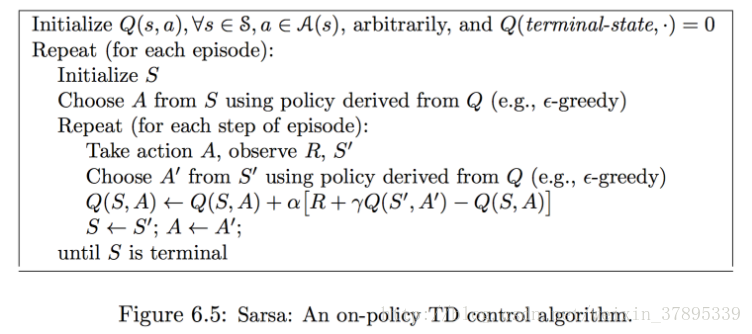
Q-learning is a model-free reinforcement learning algorithm to learn the value of an action in a particular state. It does not require a model of the environment (hence "model-free"), and it can handle problems with stochastic transitions and rewards without requiring adaptations.  
Q(st, at) = Q(st, at) + α*(rt + γ*maxa Q(st+1, a) - Q(st, at))

## 14. Explain the SARSA algorithm. (5 Points)  
### pseudocode
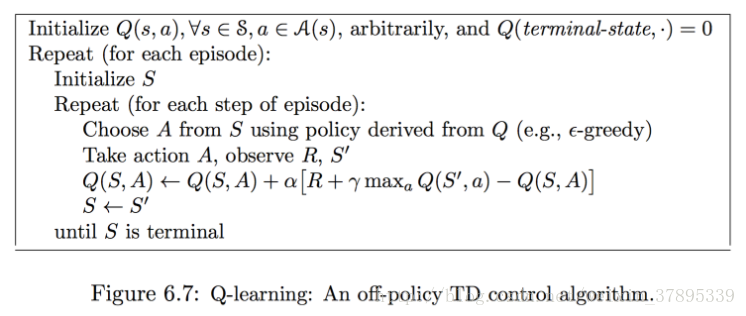
State–action–reward–state–action (SARSA) is an algorithm for learning a Markov decision process policy, used in the reinforcement learning area of machine learning. It was proposed by Rummery and Niranjan in a technical note[1] with the name "Modified Connectionist Q-Learning" (MCQ-L). The alternative name SARSA, proposed by Rich Sutton, was only mentioned as a footnote.  
Q(st, at) = Q(st, at) + α*(rt + γ*Q(st+1, at+1) - Q(st, at))
 

## 15. What code is yours and what have you adapted? (5 Points)
I use the implementation by Behçet Şentürk in GitHub (https://github.com/bhctsntrk/OpenAIPong-DQN), changed the parameters to adapt the questions and run for different groups of parameters. 
 
## 16. Did I explain my code clearly? (10 Points)
Your code review score will be scaled to a range of 0 to 10 and be used for this score.
 

## 17. Did I explain my licensing clearly? (5 Points)

copyright (c) 2022, Xinlin Ying All rights reserved.

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
 